<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Compare-methods" data-toc-modified-id="Compare-methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare methods</a></span></li><li><span><a href="#Analyze-clustering" data-toc-modified-id="Analyze-clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze clustering</a></span></li><li><span><a href="#Is-our-clustering-stable-across-waves?" data-toc-modified-id="Is-our-clustering-stable-across-waves?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Is our clustering stable across waves?</a></span></li><li><span><a href="#Soft-Clustering-(Fuzzy-K-means)" data-toc-modified-id="Soft-Clustering-(Fuzzy-K-means)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Soft Clustering (Fuzzy K-means)</a></span></li><li><span><a href="#consistency-regarding-only-continuous-(repeated-in-different-waves)-questions" data-toc-modified-id="consistency-regarding-only-continuous-(repeated-in-different-waves)-questions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>consistency regarding only continuous (repeated in different waves) questions</a></span><ul class="toc-item"><li><span><a href="#Deviations-for-the-same-opinion-questions-across-the-waves" data-toc-modified-id="Deviations-for-the-same-opinion-questions-across-the-waves-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Deviations for the same opinion questions across the waves</a></span></li><li><span><a href="#Checking-consistency-of-confidently-clustered-samples-among-the-same-questions-in-different-waves" data-toc-modified-id="Checking-consistency-of-confidently-clustered-samples-among-the-same-questions-in-different-waves-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Checking consistency of confidently clustered samples among the same questions in different waves</a></span></li></ul></li></ul></div>

# Clustering

Initially we looked at correlation between features and noticed that the largest ones (in terms of magnitude) appeared amongst the **opinion** question. So the question arose
> Can we group participants into two classes based on their political opinion?


In [1]:
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sys.path.insert(0, "../utils/")
import csv
import warnings

import ipywidgets as widgets
import numpy as np
import pandas as pd

# import seaborn as sns
from dictionaries_rename import (
    get_binary_names,
    get_dummies_names,
    get_ordinal_names,
    opinion_questions,
)
from ipywidgets import interact
from scipy.spatial.distance import cdist
from sklearn import cluster
from sklearn.decomposition import PCA
from utils_clustering import (
    compare_4_clusters,
    delete_unique,
    individual_check,
    plot_clusters,
    plot_deviations,
    plot_left_right,
    plot_mean_label,
    plot_party_choice,
    plot_stability,
    real_or_nan,
    save_fig,
    show_features,
    sort_by_absolute_val,
    store_results,
    waves_to_switch,
)

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)

## Prepare data

- Input: `data_online_political_w{wave}.csv`
- Output for each wave: 
    * `df_opinions`  without wrong check questions, no shows removed, feature names prettified, immigration relared questions tagges, 
    * `left_right` placement, obtained either from *LEFT-RIGHT SELF-PLACEMENT* or *PREFERRED COALITION: OEVP-FPOE* (if no self-placement is available);
    * `party_choice` (based on *PARTY CHOICE: PROSPECTIVE*)

In [2]:
%run Prepare_clustering_data.ipynb

The number of people who answered one of the check questions incorrectly is 1207.


The questions from the list below were asked only once, but in different waves, therefore makes no sense to use them when it is splitted into e.g. 3 columns in 3 waves with random samples.
However when I removed them, the clustering assignment stability became a waste as these questions were the most important ones (even when too namy NaNs are replaced by mode

## Compare methods

In this section we investigated different clustering methods performance (with Kmeans being the most efficient one) and tried to obtain the most optimal number of clusters (which eventually is 2). For more details, see [Compare_clustering_methods notebook](./Compare_clustering_methods.ipynb)

## Analyze clustering

We use the Kmeans algorithm since it performed the best in the previous evaluations. This method not only compute a clustering but also a *centroid* for every cluster and the distance of every point to those centers. Every point will simply be assigned to the centroid to which it has this smallest distance. If the distance of a point to its centroid is much smaller than its distance to the other centroid we tend to be more confident in it's assignment. So we compute quotient of the distances to the two centroids. Next we compute the median of all quotients of all points in a class and call the closest half *close* and the half that is further away than this median *far*.

In [3]:
def add_closeness_label(df, n):
    """Given a clustering in a dataframe decide for every point whether it is
    close of far from its centroid. This should reflect the confidence with
    which the point is assinged to its cluster."""

    df["Distance"] = np.NaN
    for label in range(n):
        df_label = df.loc[df.Label == label]
        threshold = df_label["quotient"].quantile(0.8)

        df.loc[df.Label == label, "Distance"] = df_label["quotient"].apply(
            lambda x: 0 if x > threshold else 1
        )  # close => 1, far => 0

    return df


def compute_clusters(X, n):
    """Clusters dataset into n groups and additionally asigns every point a label
    depending on whether it is 'close' and 'far' from centroid,
    hoping that close ones are clustered more confidently
    """

    kmeans = cluster.KMeans(n_clusters=n, random_state=42).fit(X)
    X_dist = kmeans.transform(X)
    quotient = X_dist.min(axis=1) / X_dist.max(axis=1)
    df_cluster = pd.DataFrame(quotient, columns=["quotient"])
    df_cluster.index = X.index
    df_cluster["Label"] = kmeans.labels_
    centroids = kmeans.cluster_centers_

    df = add_closeness_label(df_cluster, n)

    return df, centroids

For illustration purposes we also compute a principal component analysis (PCA) of all the opinion question which allows us to visualize the obtained clustering and centroids in a lower dimensional space.

In [4]:
def reduce_dims(df, centroids):
    """Compute PCA of opinion questions and transform data and centroids into new
    coordinate system for plotting"""

    # 2 components for 2D visualization
    pca = PCA(n_components=2)
    pca.fit(df)

    explained_variance = pd.DataFrame(pca.explained_variance_ratio_).T

    # obtain data transformed into 2 dimensions for illustration purposes
    df_pc = pd.DataFrame(pca.transform(df))
    df_pc.columns = ["1st component", "2nd component"]
    df_pc.index = df.index

    centroids_pc = pca.transform(centroids)

    # get the most important features, representing axes
    eigenvectors = pd.DataFrame(
        pca.components_.T, index=df.columns, columns=["Eigenvector 1", "Eigenvector 2"]
    )

    return df_pc, centroids_pc, explained_variance, eigenvectors

Additionally, for every question we compute the average strength of agreement for people of the same cluster and compare these values between the groups. We only list here the subset of question with the largest difference in agreement between the two groups.

In [5]:
def cluster_differences(df, wave):
    """Computes for both classes the average agreement for the different questions"""

    df_cluster_means = df.groupby(["Label"]).mean().T
    differences = (df_cluster_means[1] - df_cluster_means[0]).sort_values(
        ascending=False
    )
    strongest_differences = pd.DataFrame(differences)
    strongest_differences.columns = ["Difference"]
    strongest_differences = strongest_differences[
        ~strongest_differences.index.duplicated()
    ]

    strongest_differences = sort_by_absolute_val(strongest_differences, "Difference")
    wave_to_switch = waves_to_switch(strongest_differences, wave)

    return strongest_differences, wave_to_switch

In [6]:
def clustering_each_wave(left_right, party_choice, wave, df, n):
    """Perform clustering of given wave and compute important quantities through PCA and other methods.
    In other words, this function puts others together, making cluster analysis, dim reduction
    and plotting
    """
    df_cluster, centroids = compute_clusters(df, n)

    # compute coordinates with respect to new basis
    df_pc, centroids_pc, explained_variance, eigenvectors = reduce_dims(df, centroids)

    # plotting
    df_plot = pd.concat([df_pc, df_cluster.Label, df_cluster.Distance], axis=1)
    plot_left_right(left_right, df_plot, centroids_pc, wave)

    # the question about party choice was asked only in waves 1-4
    if wave in {
        "1",
        "2",
        "3",
        "4",
    }:
        plot_party_choice(party_choice, df_plot, centroids_pc, wave)

    # add cluster label column
    df = pd.concat([df, df_cluster["Label"]], axis=1)

    # different functions to obtain the most important factors for different numbers of clusters
    if n == 2:
        strongest_differences, wave_to_switch = cluster_differences(df, wave)
    else:
        strongest_differences = compare_4_clusters(df, wave)
        wave_to_switch = []
    cluster_w = df_cluster.drop(columns="quotient")
    cluster_w = cluster_w.rename(
        {"Label": f"Label w{wave}", "Distance": f"Close to centroid w{wave}"}, axis=1
    )
    clustering_info = store_results(
        df, explained_variance, eigenvectors, strongest_differences, wave
    )
    all_waves_clustering_info = {}
    all_waves_clustering_info[wave] = clustering_info
    return cluster_w, all_waves_clustering_info, wave_to_switch

### Execution 2 clusters

Execute `clustering_each_wave` for 2 clusters and every wave

Switch label signs for wave: 1
Switch label signs for wave: 2
Switch label signs for wave: 3
Switch label signs for wave: 4
Switch label signs for wave: 5


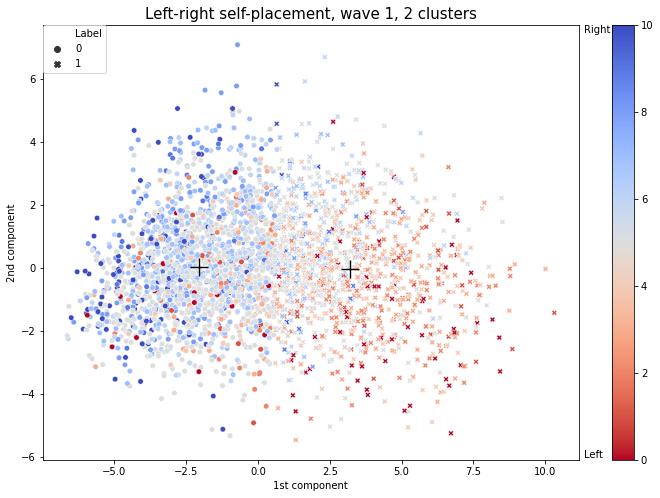

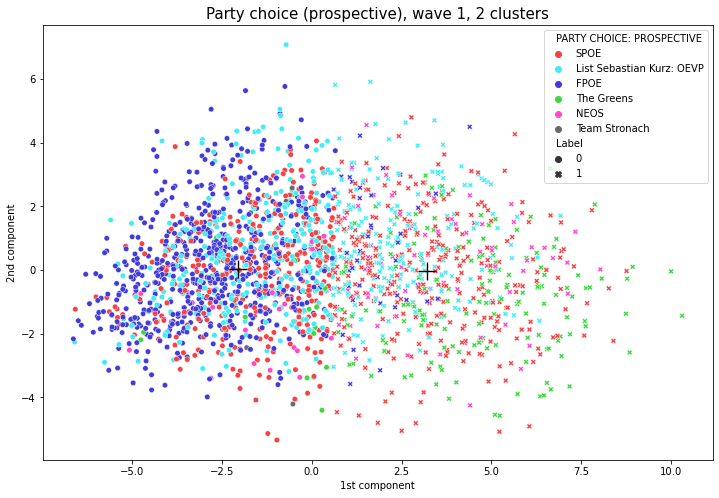

In [7]:
df_clustered = pd.DataFrame()
all_waves_clustering_info_2 = {}
list_to_switch = []
for wave in waves:
    (
        df_clustered_w,
        all_waves_clustering_info_2[wave],
        wave_to_switch,
    ) = clustering_each_wave(left_right, party_choice, wave, df_opinion[wave], 2)
    list_to_switch.append(wave_to_switch)
    df_clustered = pd.concat([df_clustered, df_clustered_w], axis=1)

#### Wave 1 results

In [8]:
for key, values in all_waves_clustering_info_2["1"].items():
    for key_, values_ in values.items():
        display(values_[:5].style.set_caption(key_))

,0,1
0,0.27,0.08


,Eigenvector 1
im: IMMIGRATION TO AUSTRIA ONLY IN EXCEPTIONAL CASES,0.33
im: CRIME RATES INCREASE IN AUSTRIA BECAUSE OF IMMIGRANTS,0.28
im: IMMIGRANTS ENRICH AUSTRIAN CULTURE,-0.27
im: SAME ACCESS TO SOCIAL BENEFITS: EASTERN EUROPEANS (NEW EU MEMBER STATES),-0.27
im: SAME ACCESS TO SOCIAL BENEFITS: NON-AUSTRIANS,-0.27


,Eigenvector 2
FAVOR WOMEN WITH EQUAL QUALIFICATION AT JOB APPLICATION,0.30
POLITICIANS ONLY CARE ABOUT THE INTERESTS OF THE RICH AND POWERFUL,0.30
INCOME DIFFERENCES ARE TOO LARGE IN AUSTRIA,0.29
THE PARTIES ARE THE MAIN PROBLEM IN AUSTRIA,0.27
PREFER INDEPENDENT CITIZEN INSTEAD OF A PARTY MEMBER,0.27


,Difference
im: IMMIGRATION TO AUSTRIA ONLY IN EXCEPTIONAL CASES,1.78
im: CRIME RATES INCREASE IN AUSTRIA BECAUSE OF IMMIGRANTS,1.52
im: IMMIGRANTS ENRICH AUSTRIAN CULTURE,-1.46
im: SAME ACCESS TO SOCIAL BENEFITS: ASYLUM SEEKERS,-1.45
im: SAME ACCESS TO SOCIAL BENEFITS: NON-AUSTRIANS,-1.44


The table 2 with 1st eigenvector clearly shows, that the most of division between clusters can be explained solely by immigtration related questions (which are tagged with *im*). Same can be observed on the plot (Left-right self-placement) above: separation is almost vertical (1st component is represented by x-axis). We would like to remind, that opinion questions are coded in the following way:
* 1 - completely agree 
* 2 - somewhat agree
* 3 - partly agree/disagree/don't know
* 4 - somewhat disagree 
* 5 - completely disagree

Therefore, larger values of eigenvector coefficients mean more disagreement. Moving towards the right side of x-axis on this plot means more pro-immigrant position.
In other words, cluster 0 is more immigrant-friendly, than cluster 1. 

That corresponds the results from table 4: there we substract mean opinion values of cluster 0 from cluster 1. On top of that we see the match with colors of self left-right placement, when cluster 0 is colored mostly with red and cluster 1 is predominantly blue. There are many grey dots, which can be explained by the fact, that most of the people prefer option closer to the middle. 

For illustration purposes we leave wave 1 results permamently visible. For the access to the other waves please run the notebook and use the widget below

In [9]:
# Store the tables as csv
for wave in waves:
    for component, table in zip([1, 2], [2, 3]):
        round(
            all_waves_clustering_info_2[wave][wave][
                f"Table {table}. Important features (PCA), {component} component, wave {wave}"
            ][:5],
            3,
        ).to_csv(f"../../../output/component{component}_wave{wave}.csv")

### Execution 4 clusters

Execute `clustering_each_wave` for 4 clusters and every wave.

In [10]:
%%capture
# line 1 prevents 4 clusters plotting (use the widget below)

all_waves_clustering_info_4 = {}
for wave in waves:
    (
        df_clustered_w,
        all_waves_clustering_info_4[wave],
        wave_to_switch,
    ) = clustering_each_wave(left_right, party_choice, wave, df_opinion[wave], 4)

### Results (all waves)

Here it is possible to input values such as wave and number of clusters and get the result without scrolling

In [11]:
@interact
def interactive_results(wave=waves, clusters=[2, 4]):
    show_features(
        wave, clusters, all_waves_clustering_info_2, all_waves_clustering_info_4
    )
    plot_clusters(wave, clusters, left_right)

interactive(children=(Dropdown(description='wave', options=('1', '2', '3', '4', '5', '6'), value='1'), Dropdow…

## Is our clustering stable across waves?

We start with the following premise:
> Political opinions of people in general don't vary much in short periods of time.

If this is indeed the case it makes sense to look at our clustering across different waves and check if participants are constantly assigned to the same cluster? It should be noted here that it's not so easy to define what we mean by "same" cluster as there are no external labels. However, by looking for example at the question with the biggest difference between the two clusters we can see a clear nationalist-liberal trend and can therefore manually give meaning to the two classes.


In [12]:
def switch_labels(list_to_switch, df):
    """switch labels 1 and 0 for clusters check cluster consistency"""
    # drop None values, which mean, that no changes of labels needed
    list_to_switch = [wave for wave in list_to_switch if wave is not None]
    # make signs corresponding
    for wave in list_to_switch:
        df[f"Label w{wave}"] = abs(df[f"Label w{wave}"] - 1)
    return df

In [13]:
df_clustered = switch_labels(list_to_switch, df_clustered)

For each participant we then compute the `mean` of their respective labels across waves. If they have  been assigned the label $1$ in all waves in which they participated, then the mean is $1$. Analogously for label $0$. If the mean of the labels of a given participant is strictly between $0$ and $1$ this means that they have not been assigned the same group in all waves. The mean being close to $0$ or $1$ indicates that a person has been given the same label *most of the time*.

Naturally, we assume that political opinions of people, no matter the topic, are not black or white, but located on a spectrum. People who are located somewhere in the middle might be assigned a different cluster in later waves even if their opinion did not change. For this reason we want to see if the assignment of clusters across waves becomes even more stable if we only consider people that are much closer to their centroid then they are to the other one. In some sense those people are clustered more confidently.

On top of that we also want to see whether cluster assignment becomes more stable when we exclude wave 6 as there are no immigration related questions, which are usually the most important ones.

In [14]:
df_close = df_clustered.copy()
print("Rate of included participants (close to centroids):")
for wave in waves:
    df_close = df_close.loc[df_close[f"Close to centroid w{wave}"] != 0]
    included_rate = (
        df_close.count(axis=0)[int(wave) * 2 - 1]
        / df_clustered.count(axis=0)[int(wave) * 2 - 1]
    )
    print(f"wave {wave}: ", np.int(included_rate * 100), "%", sep="")

Rate of included participants (close to centroids):
wave 1: 79%
wave 2: 68%
wave 3: 63%
wave 4: 57%
wave 5: 53%
wave 6: 45%


Considering only people which are close to centroids during all waves, we eventually leave only 44% of samples. So we also want to know the picture with all people, who were closely assigned at least once.

In [15]:
%matplotlib inline
@interact
def interactive_stability(
    include=["always closely located samples", "samples close at least once"],
    exclude_wave_6=True,
):
    plot_stability(include, exclude_wave_6, df_clustered, df_close)

interactive(children=(Dropdown(description='include', options=('always closely located samples', 'samples clos…

Evidently, most of the people are assigned to the same group all the time.

Not confident samples are those, whose probability to be assigned to any cluster is lower than threshold (e.g. 30% to cluster 0 and 30% to cluster 1 while threshold is 65%)

## consistency regarding only continuous (repeated in different waves) questions

### Deviations for the same opinion questions across the waves

In [16]:
cols_names = []
for wave in waves:
    list_wave = df_opinion[wave].columns
    cols_names.extend(list_wave)

In [17]:
cols_names = delete_unique(cols_names)

In [18]:
# merging all waves opinions into 1 df with all waves to check consisency among the same questions afterwards
opinion_all_waves = pd.DataFrame([])
for wave in waves:
    opinion_all_waves = pd.concat([opinion_all_waves, df_opinion[wave]], axis=1)

In [19]:
def find_deviations(df, cols_names):
    """creates dataframes for every question, containing only columns with that particular question
    with number of cols equal to number of times question was asked among the waves, finds the difference between
    max and min opinions

    :input:
    - merged df with all opinions for all the waves
    - names of questions repeated aming different waves at least twice

    :return:
    - difference between max and min value of opinion

    """
    deviations = pd.DataFrame([])
    for question in cols_names:
        df_ = df.filter(like=question, axis=1)
        # some people answered the question only once, we do not want to include them
        # as algorithm will consider them as never deviated, so they are marked as NaN
        df_["Number of responces"] = df_.count(axis=1)
        df_ = df_.mask(df_["Number of responces"] == 1)
        df_.drop(["Number of responces"], axis=1, inplace=True)
        df_ = df_.max(axis=1) - df_.min(axis=1)
        deviations = pd.concat([deviations, df_], axis=1)
    deviations.columns = cols_names
    return deviations

In [20]:
opinion_deviations = find_deviations(opinion_all_waves, cols_names)

Previously we observed peaks in terms of number of people who significantly changed their opinions for some questions. But when we checked these outliers it turned out, that this is caused by the fact that some questions were asked only once for each person, but during different waves. During preparation step we changed NaN into neutral option (2), which caused peaks for some questions. These questions need to be removed first.

In [21]:
# get df with initial features codes
dict_ordinals = get_ordinal_names()
dict_ordinals = pd.DataFrame(dict_ordinals.items(), columns=["key", "fname"])
dict_ordinals.index = dict_ordinals["fname"]
dict_ordinals.drop(["fname"], axis=1, inplace=True)
dict_ordinals = dict_ordinals.T
dict_ordinals.columns = dict_ordinals.columns.str.split("-w").str[0]

In [22]:
# check how many NaN questions have, if rate >= 50%, then the question was asked only once, makes no sense to use it for stability check
df_init = pd.read_csv("../../../data/10017_da_en_v2_0.tab", sep="\t")
nan_list = []
for question in cols_names:
    if "im" in question:
        question = question.split("im: ")[1]
    codes = (dict_ordinals[question]).values.tolist()[0]
    nan_rate = df_init[codes].isna().sum().sum() / (
        df_init[codes].shape[0] * df_init[codes].shape[1]
    )
    nan_list.append(nan_rate)
df_nan = pd.DataFrame([nan_list], columns=cols_names, index=["NaN rate"]).T
df_nan.sort_values(by="NaN rate", ascending=False, inplace=True)

In [23]:
asked_once = df_nan[df_nan["NaN rate"] >= 0.5]
asked_once_cols = asked_once.index
display(asked_once)

,NaN rate
im: MUSLIMS ARE RARELY DISCRIMINATED AGAINST IN AUSTRIA,0.73
im: MUSLIMS HAVE FEWER CHANCES IN AUSTRIA,0.73
im: ANGRY WHEN MUSLIMS ARE DISCRIMINATED AGAINST BECAUSE OF BELIEFS,0.73
im: FEELING LIKE A STRANGER DUE TO THE MANY MUSLIMS,0.73
im: EUROPEAN AND MUSLIM LIFESTYLE ARE EASILY COMPATIBLE,0.73


In [24]:
# drop the above mentioned questions
opinion_deviations.drop([asked_once.index][0], axis=1, inplace=True)

In [25]:
nans = opinion_deviations.isnull().sum().to_frame()
# group deviations by its degrees for each question
opinion_deviations = opinion_deviations.apply(pd.value_counts).T
opinion_deviations = pd.concat([opinion_deviations, nans], axis=1)
opinion_deviations.columns = [0, 1, 2, 3, 4, "NaN"]
opinion_deviations.drop("NaN", axis=1, inplace=True)
opinion_deviations = opinion_deviations.sort_values(
    [4, 3, 2], ascending=(True, True, True)
).T
# since the questions were not asked always and sometimes number of respondents is vastly different, deviations stats converted into petcentages
opinion_deviations = (100.0 * opinion_deviations / opinion_deviations.sum()).round(2)

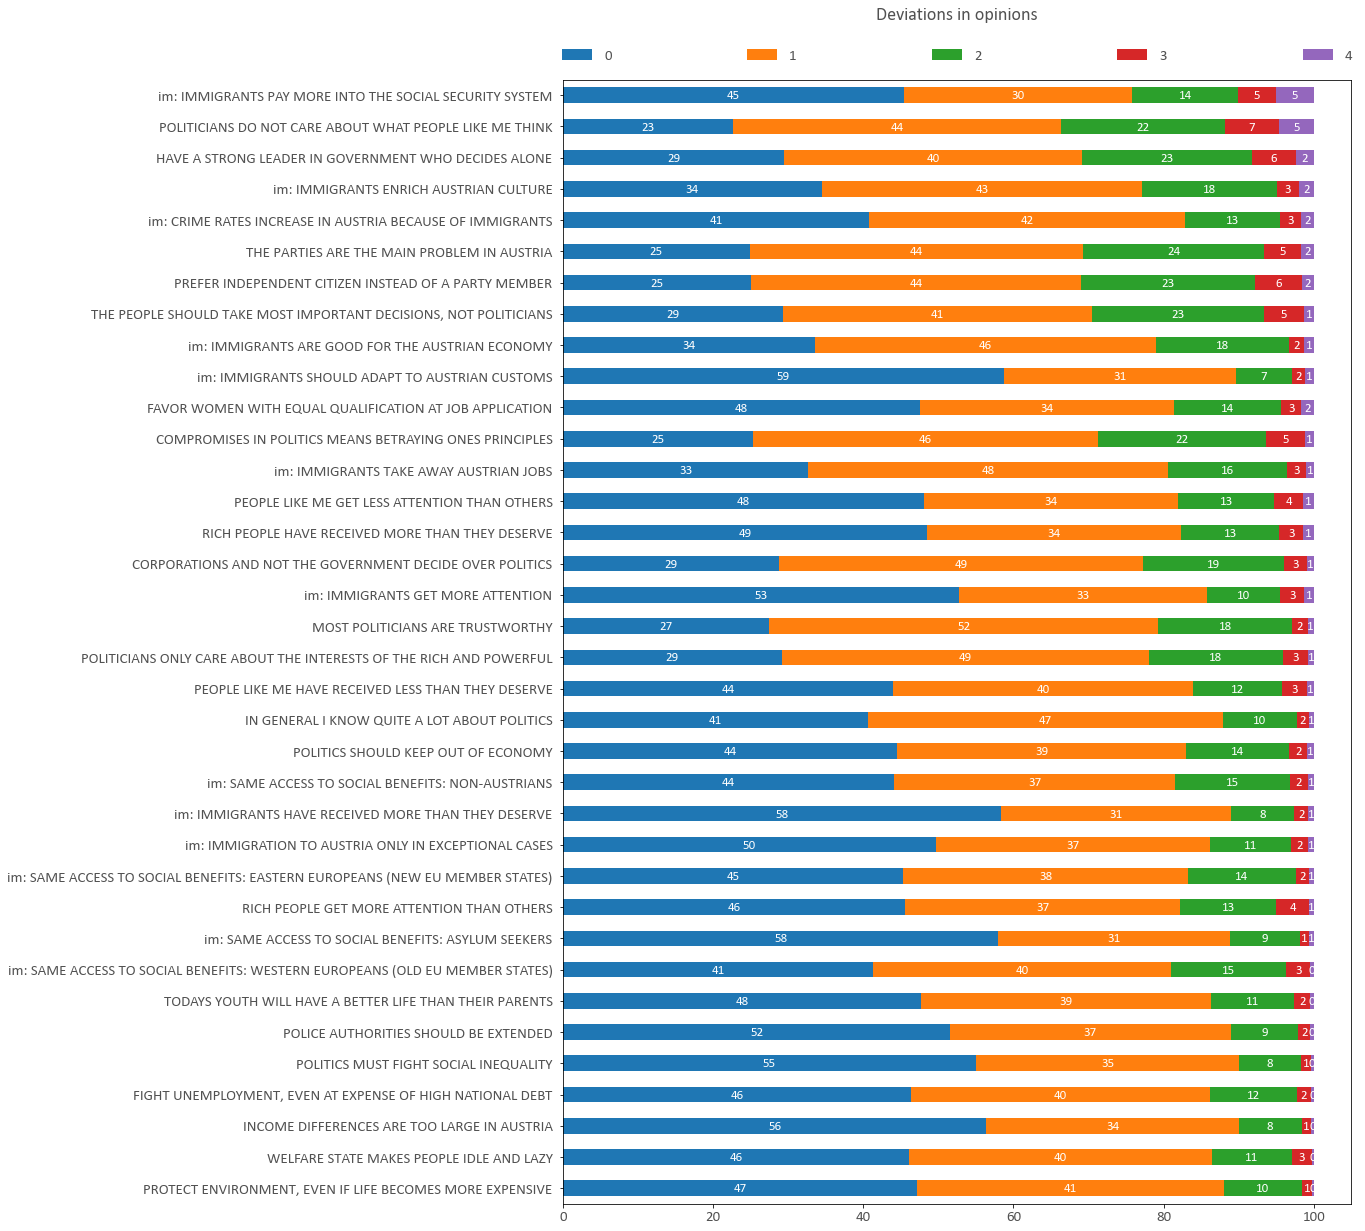

In [26]:
plot_deviations(opinion_deviations)

The plot above shows that there are up to 10-12% of people, significantly changing their opinions about particular questons. This might explain the fact, that if we have rate of those, who never change their cluster assignment

### Labels heatmap across the waves

In this plot we filter only people, which are always close to centroids (therefore only participants, which never drop were included) to individually check if they were confidently assigned to the same cluster or not

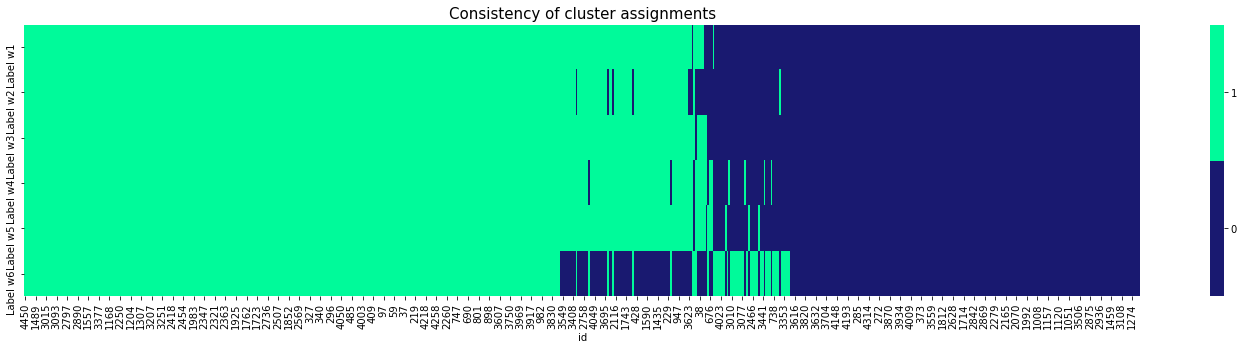

In [27]:
individual_check(df_clustered, waves)

Cluster assignment is literally the same for them across the waves. Cluster 6 does not contain any immigration questions (causing the largest differences), therefore it is not possible to adequately compare it with others. However, if we delete immigration opinions to have the same base, that might change.

In [28]:
# convert this notebook to pdf but without the code
#!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True --output-dir=output_pdf clustering.ipynb